# Deep Learning Study - Executable PFR

## Import des modules

In [ ]:
import sys
sys.path.insert(0, '../')

import numpy as np
import src.plot_deep as plt_d
import src.models as md
import src.utils_deep as ud
import src.utils_preprocessing as up
import src.import_data as id
import pandas as pd

import torch
import torch.nn.functional as F
import numpy
import matplotlib.pyplot as plt
# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


c:\Users\grani\anaconda3\envs\torch_cuda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Définition du device de calcul - CPU vs GPU

## Import de la donnée

In [ ]:
df_merged = id.import_data_merged(file_name="../data/merge/data_merged.csv")
embedding = np.load("../data/embeddings/embeddings_combined.npy")
vars_expl = id.vars_expl
vars_cibles = id.vars_cibles

emb_avec, emb_sans, X_avec, X_sans, y_avec, y_sans = id.sep_extr_X_y(df_merged, embedding, vars_expl= vars_expl, vars_cibles=vars_cibles, Nom_a_separer="Avoine" )

✓ Data loaded
  - df_merged shape: (6574, 28)
✓ Data séparée sur : Avoine
  - df_sans shape: (6473, 28)
  - df_avec shape: (101, 28)
Vérification - Avec : (101, 768) - Sans : (6473, 768)
Transformation faites - X_vars : (101, 10) - y : (101, 11)
Transformation faites - X_vars : (6473, 10) - y : (6473, 11)


## Création du dataset pour l'entrainement de l'encoder

In [4]:
train_loader_emb, val_loader_emb, test_loader_emb, scaler_X_emb, scaler_y_emb = up.split_2_DataLoader(emb_sans, emb_sans, val_size=0.8)
print("Taille Dataset Train :", len(train_loader_emb.dataset))
print("Taille Dataset Val :", len(val_loader_emb.dataset))
print("Taille Dataset Test :", len(test_loader_emb.dataset))

Taille Dataset Train : 3883
Taille Dataset Val : 2072
Taille Dataset Test : 518


## Partie Encodeeur
### Définition du modèle

In [5]:
model_auto_encoder = md.MirrorAutoEncoder().to(device)
optimizer_auto = torch.optim.AdamW(model_auto_encoder.parameters(), lr=1e-3, weight_decay=1e-4)
criterion_auto = F.smooth_l1_loss

### Entrainement du modèle

  0%|          | 1/500 [00:00<03:43,  2.23it/s]

Epoch   1 | Train                 0.1582 | Val 0.0391


  2%|▏         | 11/500 [00:04<02:51,  2.85it/s]

Epoch  11 | Train                 0.0108 | Val 0.0085


  4%|▍         | 21/500 [00:07<02:46,  2.88it/s]

Epoch  21 | Train                 0.0069 | Val 0.0074


  6%|▌         | 31/500 [00:11<02:52,  2.72it/s]

Epoch  31 | Train                 0.0052 | Val 0.0058


  8%|▊         | 41/500 [00:14<02:50,  2.70it/s]

Epoch  41 | Train                 0.0043 | Val 0.0061


 10%|█         | 51/500 [00:18<02:49,  2.64it/s]

Epoch  51 | Train                 0.0038 | Val 0.0063


 12%|█▏        | 61/500 [00:22<02:48,  2.61it/s]

Epoch  61 | Train                 0.0036 | Val 0.0065


 14%|█▍        | 71/500 [00:26<02:42,  2.65it/s]

Epoch  71 | Train                 0.0040 | Val 0.0063


 16%|█▌        | 81/500 [00:30<02:39,  2.62it/s]

Epoch  81 | Train                 0.0023 | Val 0.0066


 18%|█▊        | 91/500 [00:34<02:36,  2.61it/s]

Epoch  91 | Train                 0.0011 | Val 0.0050


 20%|██        | 101/500 [00:38<02:40,  2.49it/s]

Epoch 101 | Train                 0.0027 | Val 0.0062


 22%|██▏       | 111/500 [00:41<02:24,  2.70it/s]

Epoch 111 | Train                 0.0008 | Val 0.0051


 24%|██▍       | 121/500 [00:45<02:19,  2.71it/s]

Epoch 121 | Train                 0.0021 | Val 0.0083


 26%|██▌       | 131/500 [00:49<02:29,  2.47it/s]

Epoch 131 | Train                 0.0023 | Val 0.0062


 28%|██▊       | 141/500 [00:53<02:26,  2.46it/s]

Epoch 141 | Train                 0.0003 | Val 0.0050


 28%|██▊       | 142/500 [00:54<02:17,  2.61it/s]


Early stopping at epoch 143
Training complete. Best val loss: 0.0048


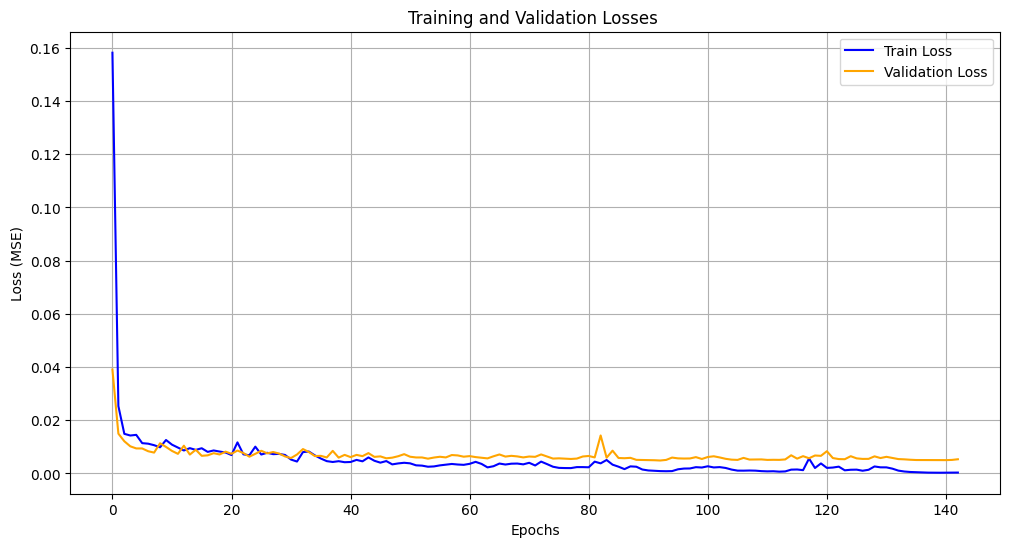

Weights saved to model_auto_Ba.pth


In [ ]:
model_auto_encoder, history_auto = ud.train_model(model_auto_encoder, train_loader_emb, val_loader_emb,optimizer_auto, criterion_auto, device)

train_loss_auto = history_auto["train_loss"]
val_loss_auto = history_auto["val_loss"]

plt_d.plot_loss_values_TV(train_loss_auto, val_loss_auto)

ud.save_weights("../models/model_auto_Ba.pth", model_auto_encoder)

frozen_encoder = md.FrozenEncoder(model_auto_encoder.encoder).to(device)

### Passage en inférence des données

In [7]:
# Transformation en tensor

X_emb_sans = torch.FloatTensor(emb_sans).to(device)
X_emb_avec = torch.FloatTensor(emb_avec).to(device)

# Inférence et réduction de dimensions

X_red_sans = frozen_encoder(X_emb_sans)
X_red_avec = frozen_encoder(X_emb_avec)

# Concaténation

X_combined_red_sans = np.hstack([X_red_sans.to("cpu"), X_sans])
X_combined_red_avec = np.hstack([X_red_avec.to("cpu"), X_avec])

In [8]:
train_loader_MLP, val_loader_MLP, test_loader_MLP, scaler_X_MLP, scaler_y_MLP = up.split_2_DataLoader(
    X_combined_red_sans, y_sans, train_size=0.7, val_size=0.8
    )

print("Taille Dataset Train :", len(train_loader_emb.dataset))
print("Taille Dataset Val :", len(val_loader_emb.dataset))
print("Taille Dataset Test :", len(test_loader_emb.dataset))

Taille Dataset Train : 3883
Taille Dataset Val : 2072
Taille Dataset Test : 518


In [9]:
X_avec_scaled = scaler_X_MLP.transform(X_combined_red_avec)
y_avec_scaled = scaler_y_MLP.transform(y_avec)

avec_dataloader = up.tensor_2_DataLoader(X_avec_scaled, y_avec_scaled, shuffle_value=False)

In [ ]:
model_MLP = md.MLPRegressor(input_size=26, hidden_sizes=[128, 256, 64], output_size=11, dropout_rate=0.2).to(device)
model_MLP = ud.load_weights("../models/model_MLP_Ba.pth",model_MLP, device)
optimizer_MLP = torch.optim.Adam(model_MLP.parameters(), lr=0.001, weight_decay=1e-5)
criterion_MLP = torch.nn.MSELoss()

  0%|          | 1/500 [00:00<01:53,  4.40it/s]

Epoch   1 | Train                 0.0974 | Val 0.0368


  2%|▏         | 11/500 [00:02<01:50,  4.42it/s]

Epoch  11 | Train                 0.0463 | Val 0.0201


  4%|▍         | 21/500 [00:04<01:48,  4.40it/s]

Epoch  21 | Train                 0.0488 | Val 0.0196


  6%|▌         | 31/500 [00:07<01:52,  4.18it/s]

Epoch  31 | Train                 0.0475 | Val 0.0284


  8%|▊         | 41/500 [00:09<01:53,  4.06it/s]

Epoch  41 | Train                 0.0471 | Val 0.0232


 10%|█         | 51/500 [00:11<01:46,  4.23it/s]

Epoch  51 | Train                 0.0429 | Val 0.0182


 12%|█▏        | 61/500 [00:14<01:42,  4.30it/s]

Epoch  61 | Train                 0.0421 | Val 0.0199


 14%|█▍        | 71/500 [00:16<01:40,  4.27it/s]

Epoch  71 | Train                 0.0434 | Val 0.0187


 16%|█▌        | 81/500 [00:18<01:37,  4.30it/s]

Epoch  81 | Train                 0.0440 | Val 0.0187


 18%|█▊        | 91/500 [00:21<01:32,  4.41it/s]

Epoch  91 | Train                 0.0434 | Val 0.0203


 20%|██        | 101/500 [00:23<01:28,  4.50it/s]

Epoch 101 | Train                 0.0508 | Val 0.0249


 21%|██        | 106/500 [00:24<01:32,  4.25it/s]


Early stopping at epoch 107
Training complete. Best val loss: 0.0179


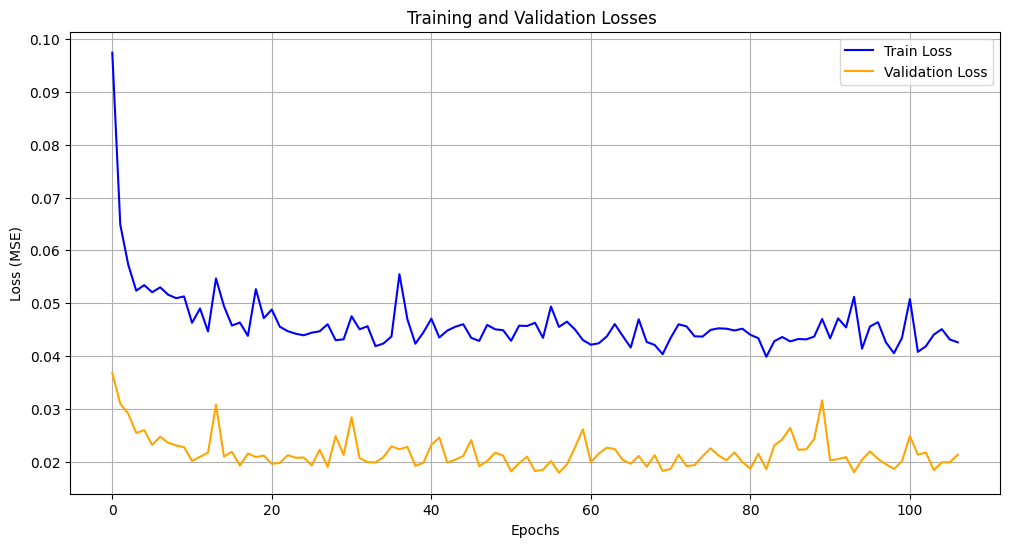

Weights saved to model_MLP_Ba.pth


In [ ]:
model_MLP, history_MLP = ud.train_model(
    model_MLP, train_loader_MLP, val_loader_MLP,optimizer_MLP, criterion_MLP, device)

train_loss_MLP = history_MLP["train_loss"]
val_loss_MLP = history_MLP["val_loss"]

plt_d.plot_loss_values_TV(train_loss_MLP, val_loss_MLP)

ud.save_weights("../models/model_MLP_Ba.pth", model_MLP)

In [12]:
results_MLP = ud.Calcul_evaluation(
    model_MLP, train_loader_MLP, val_loader_MLP, avec_dataloader, scaler_y_MLP, device, vars_cibles
    )


SCENARIO 2 Results:

Train Set:
  R²:   0.9922 (±0.0013)
  RMSE: 42.3092 (±35.2367)
  MAE:  30.3038 (±25.1749)

Validation Set:
  R²:   0.9815 (±0.0058)
  RMSE: 69.8940 (±60.1385)
  MAE:  34.0553 (±28.4684)

Test Set (OOD - Feedtables):
  R²:   -6.1368 (±9.8374)
  RMSE: 115.7070 (±102.1769)
  MAE:  108.0625 (±96.2112)


In [13]:
ud.print_regression_results(results_MLP, "MLP")


MLP - Performance per target variable:
Target                              R² (test)       RMSE            MAE            
--------------------------------------------------------------------------------
EB (kcal) kcal/kg brut              -6.619            199.74           195.25
ED porc croissance (kcal) kcal/kg   -2.043            252.63           240.19
EM porc croissance (kcal) kcal/kg   -2.007            243.68           231.49
EN porc croissance (kcal) kcal/kg   -1.654            184.60           174.62
EMAn coq (kcal) kcal/kg brut         0.079            166.28           144.15
EMAn poulet (kcal) kcal/kg brut     -0.261            192.02           170.94
UFL 2018 par kg brut                -1.402              0.07             0.06
UFV 2018 par kg brut                -2.316              0.09             0.09
PDIA 2018 g/kg brut                 -32.251             12.87            12.67
PDI 2018 g/kg brut                  -19.401             14.44            14.16
BalProRu 2018

In [14]:
X_batch, y_batch_scaled = next(iter(avec_dataloader))
X_batch = X_batch.to(device)

model_MLP.eval()
with torch.no_grad():
    y_pred_scaled = model_MLP(X_batch).cpu().numpy()

y_true_scaled = y_batch_scaled.numpy()

# revenir à l’échelle originale
y_true = scaler_y_MLP.inverse_transform(y_true_scaled)
y_pred = scaler_y_MLP.inverse_transform(y_pred_scaled)


n = 5  # nombre d'exemples à afficher

rows = []
for i in range(n):
    rows.append(["true", *y_true[i]])
    rows.append(["pred", *y_pred[i]])

df_debug = pd.DataFrame(rows, columns=["type"] + vars_cibles)
df_debug


,type,EB (kcal) kcal/kg brut,ED porc croissance (kcal) kcal/kg brut,EM porc croissance (kcal) kcal/kg brut,EN porc croissance (kcal) kcal/kg brut,EMAn coq (kcal) kcal/kg brut,EMAn poulet (kcal) kcal/kg brut,UFL 2018 par kg brut,UFV 2018 par kg brut,PDIA 2018 g/kg brut,PDI 2018 g/kg brut,BalProRu 2018 g/kg brut
0,true,3920.000000,2460.000000,2380.000000,1850.000000,2610.000000,2480.000000,0.810000,0.760000,16.999998,62.000000,-10.000001
1,pred,3736.907959,2861.910400,2765.590820,2122.115967,2622.091309,2530.268555,0.914519,0.902473,29.353178,77.160797,-17.076082
2,true,3970.000000,2580.000000,2480.000000,1880.000000,2590.000000,2460.000000,0.880000,0.850000,22.000002,69.000000,5.000002
3,pred,3763.707764,2954.750732,2853.052246,2180.446533,2671.448242,2580.262451,0.946341,0.939399,29.795305,78.052055,-7.177026
4,true,4100.000000,2760.000000,2660.000000,2030.000000,2690.000000,2560.000000,0.950000,0.920000,22.000002,70.000000,5.999999
5,pred,3829.217529,3030.318848,2921.667236,2216.468750,2684.231445,2593.045654,0.970535,0.965685,31.109854,79.631653,0.864531
6,true,4030.000000,2150.000000,2060.000000,1500.000000,2080.000000,1950.000000,0.770000,0.720000,19.999998,65.000000,-0.500001
7,pred,3891.791260,2483.197266,2378.213623,1763.598877,2175.204102,2106.519287,0.853696,0.825256,32.866306,79.056740,-14.977509
8,true,4120.000000,2690.000000,2590.000000,2000.000000,2750.000000,2620.000000,0.920000,0.890000,20.999998,68.000000,2.999999
9,pred,3844.889893,2969.892334,2868.170654,2193.051025,2680.418213,2586.627930,0.954907,0.946598,29.493082,77.403198,-9.967050


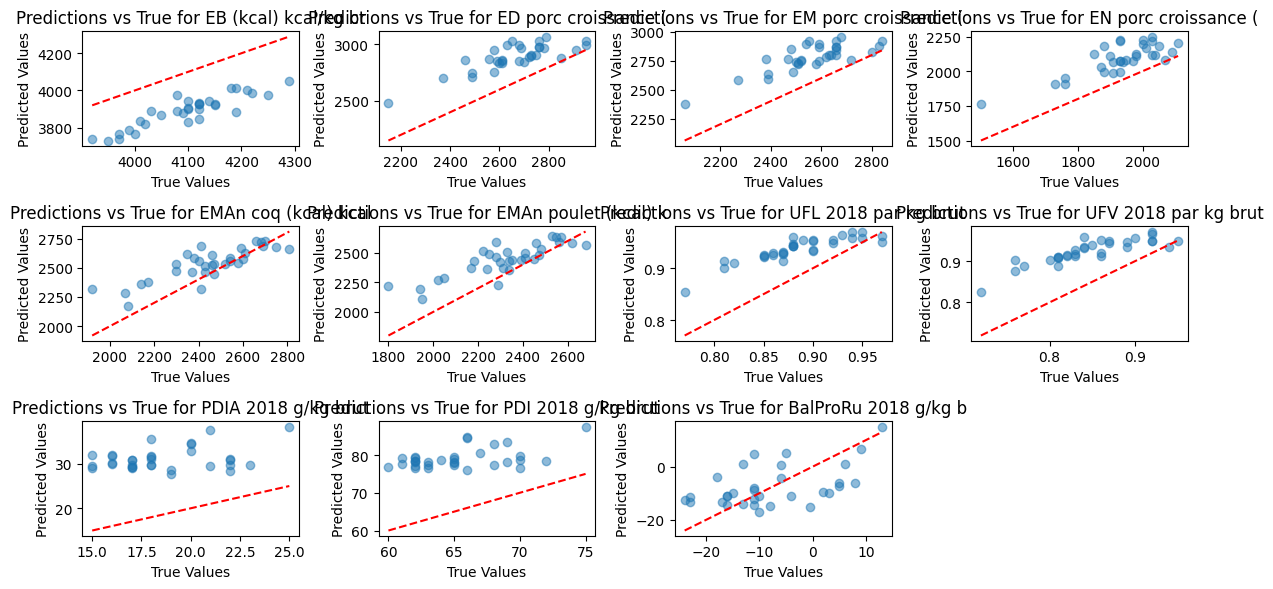

In [15]:
plt_d.plot_real_vs_pred(y_true, y_pred, vars_cibles)

## Transformers

In [ ]:
model_trans = md.NutritionTransformer().to(device)
model_trans = ud.load_weights("../models/model_trans_Ba.pth",model_trans, device)

optimizer_trans = torch.optim.AdamW(
    model_trans.parameters(),
    lr=3e-4,
    weight_decay=1e-4
)

criterion_trans = torch.nn.MSELoss()

c:\Users\grani\anaconda3\envs\torch_cuda\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


  0%|          | 1/500 [00:01<09:51,  1.18s/it]

Epoch   1 | Train                 0.0249 | Val 0.0293


  2%|▏         | 11/500 [00:11<08:25,  1.03s/it]

Epoch  11 | Train                 0.0111 | Val 0.0179


  4%|▍         | 21/500 [00:22<08:16,  1.04s/it]

Epoch  21 | Train                 0.0094 | Val 0.0114


  6%|▌         | 31/500 [00:32<07:55,  1.01s/it]

Epoch  31 | Train                 0.0094 | Val 0.0167


  8%|▊         | 41/500 [00:42<07:40,  1.00s/it]

Epoch  41 | Train                 0.0117 | Val 0.0271


 10%|█         | 51/500 [00:51<06:47,  1.10it/s]

Epoch  51 | Train                 0.0086 | Val 0.0114


 12%|█▏        | 61/500 [01:01<07:06,  1.03it/s]

Epoch  61 | Train                 0.0087 | Val 0.0129


 14%|█▍        | 71/500 [01:10<06:32,  1.09it/s]

Epoch  71 | Train                 0.0089 | Val 0.0147


 14%|█▍        | 71/500 [01:11<07:13,  1.01s/it]


Early stopping at epoch 72
Training complete. Best val loss: 0.0108


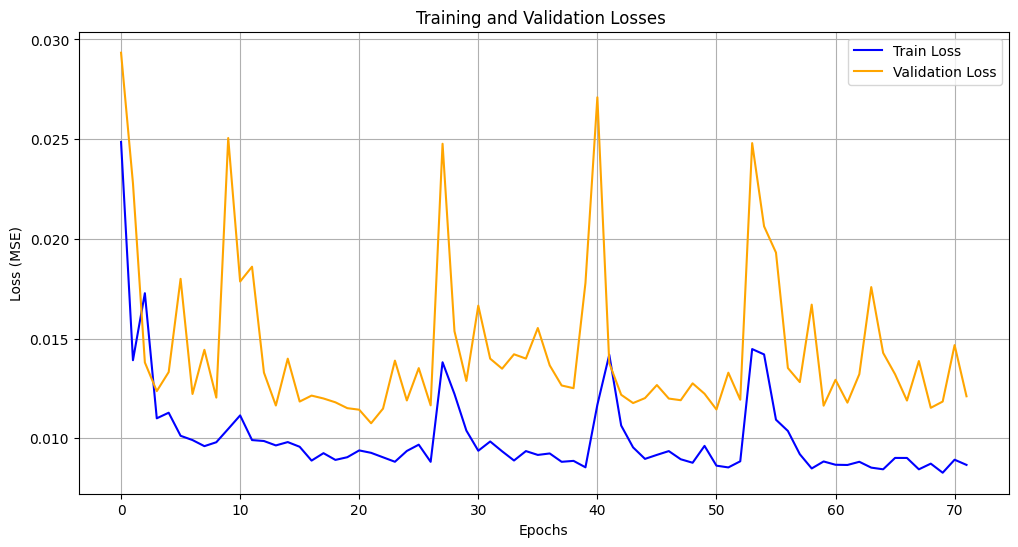

Weights saved to model_trans_Ba.pth


In [ ]:
model_trans, history_trans = ud.train_model(model_trans, train_loader_MLP, val_loader_MLP,optimizer_trans, criterion_trans, device, is_transformer=True)

train_loss_trans = history_trans["train_loss"]
val_loss_trans = history_trans["val_loss"]

plt_d.plot_loss_values_TV(train_loss_trans, val_loss_trans)

ud.save_weights("../models/model_trans_Ba.pth", model_trans)

In [18]:
results_trans = ud.Calcul_evaluation(
    model_trans, train_loader_MLP, val_loader_MLP, avec_dataloader, scaler_y_MLP, device, vars_cibles, is_transformer = True
    )


SCENARIO 2 Results:

Train Set:
  R²:   0.9970 (±0.0009)
  RMSE: 27.0245 (±23.6119)
  MAE:  18.4171 (±16.0064)

Validation Set:
  R²:   0.9889 (±0.0033)
  RMSE: 51.3825 (±43.9589)
  MAE:  21.0174 (±18.2347)

Test Set (OOD - Feedtables):
  R²:   -0.7603 (±3.4209)
  RMSE: 42.2467 (±44.9899)
  MAE:  35.9969 (±38.8481)


In [19]:
ud.print_regression_results(results_trans, "trans")


trans - Performance per target variable:
Target                              R² (test)       RMSE            MAE            
--------------------------------------------------------------------------------
EB (kcal) kcal/kg brut               0.937             18.23            12.54
ED porc croissance (kcal) kcal/kg    0.644             86.40            79.26
EM porc croissance (kcal) kcal/kg    0.667             81.11            74.21
EN porc croissance (kcal) kcal/kg    0.914             33.20            23.03
EMAn coq (kcal) kcal/kg brut         0.661            100.79            83.38
EMAn poulet (kcal) kcal/kg brut      0.448            127.04           106.35
UFL 2018 par kg brut                 0.686              0.02             0.02
UFV 2018 par kg brut                 0.657              0.03             0.03
PDIA 2018 g/kg brut                 -10.591              7.60             7.51
PDI 2018 g/kg brut                  -4.250              7.32             7.19
BalProRu 201

In [20]:
X_batch, y_batch_scaled = next(iter(avec_dataloader))
X_batch = X_batch.to(device)

model_trans.eval()
with torch.no_grad():
    y_pred_scaled_trans = model_trans(X_batch).cpu().numpy()

y_true_scaled_trans = y_batch_scaled.numpy()

# revenir à l’échelle originale
y_true_trans = scaler_y_MLP.inverse_transform(y_true_scaled_trans)
y_pred_trans = scaler_y_MLP.inverse_transform(y_pred_scaled_trans)


n = 5  # nombre d'exemples à afficher

rows_trans = []
for i in range(n):
    rows_trans.append(["true", *y_true_trans[i]])
    rows_trans.append(["pred", *y_pred_trans[i]])

df_debug_trans = pd.DataFrame(rows_trans, columns=["type"] + vars_cibles)
df_debug_trans

,type,EB (kcal) kcal/kg brut,ED porc croissance (kcal) kcal/kg brut,EM porc croissance (kcal) kcal/kg brut,EN porc croissance (kcal) kcal/kg brut,EMAn coq (kcal) kcal/kg brut,EMAn poulet (kcal) kcal/kg brut,UFL 2018 par kg brut,UFV 2018 par kg brut,PDIA 2018 g/kg brut,PDI 2018 g/kg brut,BalProRu 2018 g/kg brut
0,true,3920.000000,2460.000000,2380.000000,1850.000000,2610.000000,2480.000000,0.810000,0.760000,16.999998,62.000000,-10.000001
1,pred,3873.521973,2390.256348,2315.687012,1864.237427,2516.790771,2444.447021,0.780655,0.733919,21.689203,64.806160,-10.371652
2,true,3970.000000,2580.000000,2480.000000,1880.000000,2590.000000,2460.000000,0.880000,0.850000,22.000002,69.000000,5.000002
3,pred,3922.273438,2510.866211,2417.803467,1884.866211,2483.645264,2402.875000,0.864010,0.830558,28.172022,73.133453,2.445174
4,true,4100.000000,2760.000000,2660.000000,2030.000000,2690.000000,2560.000000,0.950000,0.920000,22.000002,70.000000,5.999999
5,pred,4089.995605,2708.289062,2607.261230,2014.122192,2592.958496,2507.238037,0.959679,0.938154,32.116703,78.509247,-2.118619
6,true,4030.000000,2150.000000,2060.000000,1500.000000,2080.000000,1950.000000,0.770000,0.720000,19.999998,65.000000,-0.500001
7,pred,3982.852783,2044.941772,1955.960449,1483.696655,2034.805542,1967.521729,0.757286,0.701065,26.676813,70.785957,-3.162458
8,true,4120.000000,2690.000000,2590.000000,2000.000000,2750.000000,2620.000000,0.920000,0.890000,20.999998,68.000000,2.999999
9,pred,4091.739502,2584.343262,2492.815918,1975.080933,2623.696533,2537.360352,0.912623,0.881017,29.704958,74.598862,-2.490217


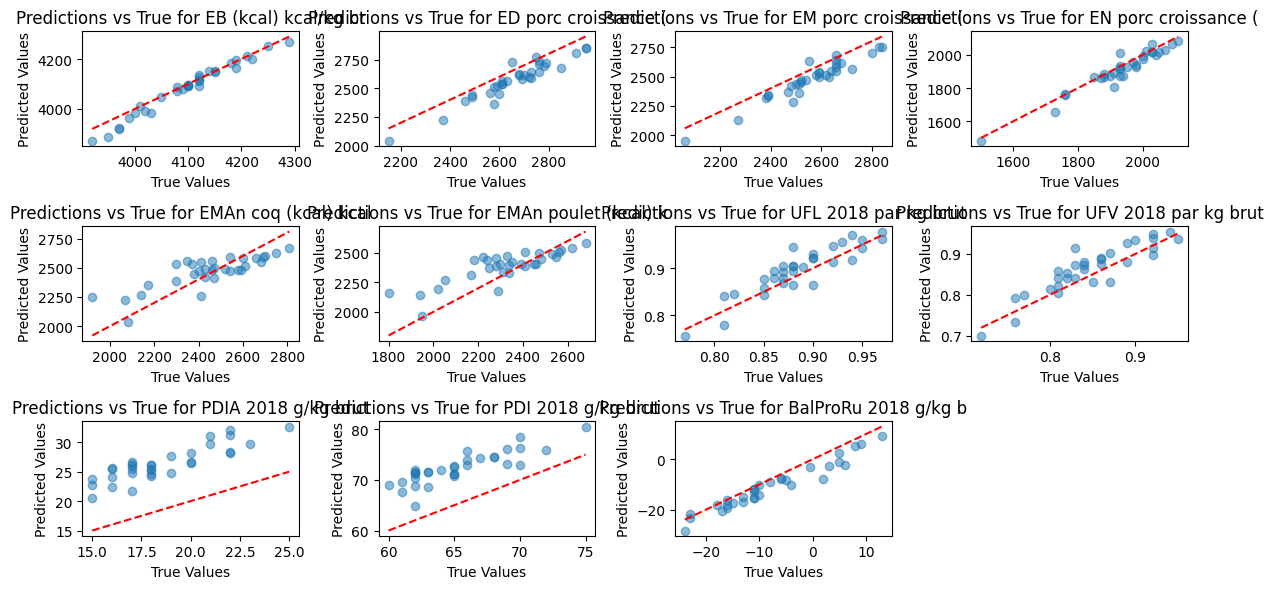

In [21]:
plt_d.plot_real_vs_pred(y_true_trans, y_pred_trans, vars_cibles)